## Examples of using delayed

NOte: To run this use the dask-tutorial environment from anaconda


In [2]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

ImportError: Dask's distributed scheduler is not installed.

Please either conda or pip install dask distributed:

  conda install dask distributed          # either conda install
  pip install dask distributed --upgrade  # or pip install

In [2]:
from dask import delayed


In [3]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

## Exercise: Parallelize a for loop¶
for loops are one of the most common things that we want to parallelize. Use dask.delayed on inc and sum to parallelize the computation below:

In [4]:
data = [1, 2, 3, 4, 5, 6, 7, 8]


In [5]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 810 ms, sys: 108 ms, total: 918 ms
Wall time: 8.02 s


In [6]:
total

44

In [7]:
%%time
# Your parallel code here...using delayed() to run the code in parallel

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum) (results)

CPU times: user 865 µs, sys: 785 µs, total: 1.65 ms
Wall time: 933 µs


In [8]:
%time total.compute()

CPU times: user 275 ms, sys: 33.2 ms, total: 308 ms
Wall time: 2.04 s


44

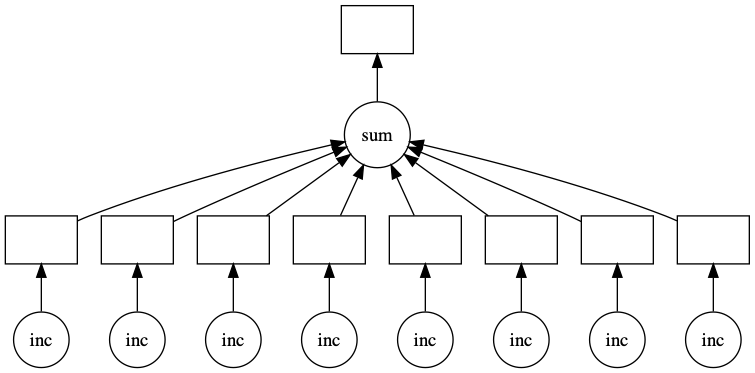

In [9]:
total.visualize()

## Exercise: Parallelizing a for-loop code with control flow
Often we want to delay only some functions, running a few of them immediately. This is especially helpful when those functions are fast and help us to determine what other slower functions we should call. This decision, to delay or not to delay, is usually where we need to be thoughtful when using dask.delayed.

In the example below we iterate through a list of inputs. If that input is even then we want to call inc. If the input is odd then we want to call double. This is_even decision to call inc or double has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [10]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 1.07 s, sys: 144 ms, total: 1.22 s
Wall time: 10 s


In [12]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

# Notice we do not delay the is_even check as its required immediately 
# to determine which function need to be called on the argument
results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)

# both of these produce the same result but have differnct compute graphs
# Experiment with each to see the difference

# total = sum(results)
# CPU times: user 3.18 ms, sys: 1.56 ms, total: 4.74 ms

total = delayed(sum)(results)
# CPU times: user 2.04 ms, sys: 1.43 ms, total: 3.46 ms

CPU times: user 2.47 ms, sys: 1.56 ms, total: 4.03 ms
Wall time: 2.77 ms


In [13]:
%time total.compute()
# without delayed(sum) CPU times: user 219 ms, sys: 25.3 ms, total: 244 ms
# with delayed(sum )   CPU times: user 212 ms, sys: 26 ms, total: 238 ms

CPU times: user 400 ms, sys: 47.8 ms, total: 448 ms
Wall time: 3.04 s


90

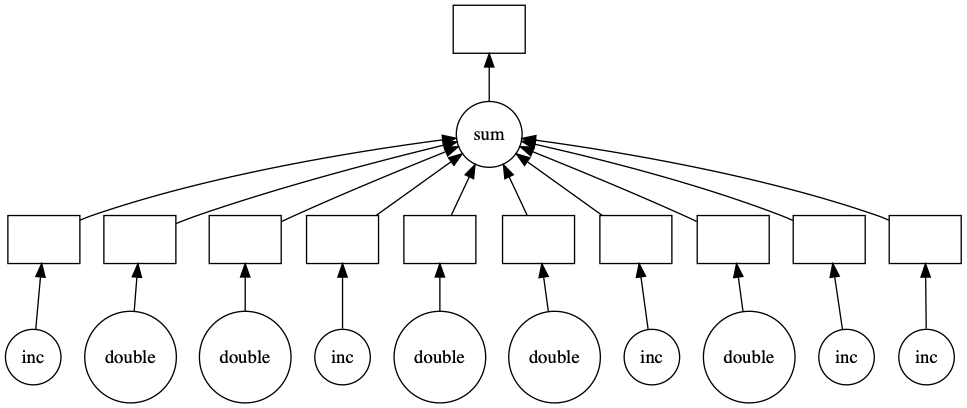

In [14]:
total.visualize()

## Exercise: Parallelizing a Pandas Groupby Reduction
In this exercise we read several CSV files and perform a groupby operation in parallel. We are given sequential code to do this and parallelize it with dask.delayed.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data. We will do this by using dask.delayed together with pandas. In a future section we will do this same exercise with dask.dataframe.

Prep data
First, run this code to prep some data, if you have not already done so.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from http://stat-computing.org/dataexpo/2009/the-data.html.

In [15]:
# inspect the data files
import os
# sorted(os.listdir(os.path.join('data', 'nycflights')))
sorted(os.listdir('/Users/dblny2/data/airline-delays'))

['1987.csv',
 '1988.csv',
 '1989.csv',
 '1990.csv',
 'The data. Data expo 09. ASA Statistics Computing and Graphics.webloc']

### Read one file with pandas.read_csv and compute mean departure delay¶


In [16]:

import pandas as pd
df = pd.read_csv('/Users/dblny2/data/airline-delays/1987.csv')
df.head()


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1987,10,14,3,741.0,730,912.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1987,10,15,4,729.0,730,903.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1987,10,17,6,741.0,730,918.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1987,10,18,7,729.0,730,847.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1987,10,19,1,749.0,730,922.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [17]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode     float64
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [18]:

# What originating airports are in the data?
df.Origin.unique()

array(['SAN', 'SFO', 'BUR', 'OAK', 'LAX', 'PHX', 'SJC', 'LAS', 'SNA',
       'SMF', 'ABQ', 'MFR', 'SCK', 'MRY', 'TUS', 'EUG', 'SEA', 'RDM',
       'PDX', 'RNO', 'ONT', 'CCR', 'FAT', 'LGB', 'PSC', 'YKM', 'BLI',
       'GEG', 'JFK', 'STL', 'HNL', 'MIA', 'SJU', 'DEN', 'CVG', 'DCA',
       'DTW', 'SYR', 'LGA', 'BOS', 'PHL', 'TPA', 'MCO', 'MKE', 'IAD',
       'CMH', 'ORD', 'PIT', 'EWR', 'HOU', 'SAT', 'DAY', 'IND', 'FLL',
       'BNA', 'CLE', 'DFW', 'BWI', 'ORF', 'COS', 'MCI', 'LIT', 'TUL',
       'BDL', 'SLC', 'SDF', 'IAH', 'JAX', 'PSP', 'ANC', 'MSY', 'OMA',
       'RSW', 'SRQ', 'ICT', 'ATL', 'MDW', 'AUS', 'MSP', 'PBI', 'OKC',
       'MLI', 'MSN', 'CLT', 'DSM', 'RDU', 'FSD', 'PIA', 'SGF', 'LEX',
       'CMI', 'CID', 'SUX', 'TOL', 'LNK', 'MDT', 'ALO', 'RST', 'MEM',
       'OGG', 'FAI', 'KOA', 'ROC', 'MBS', 'LIH', 'SBA', 'ALB', 'GSO',
       'GRR', 'BIL', 'BHM', 'CAE', 'MHT', 'ELP', 'TYS', 'JAN', 'BFL',
       'HSV', 'SAV', 'BGR', 'PWM', 'ABE', 'BOI', 'CAK', 'GTF', 'BUF',
       'CPR', 'BTV',

In [19]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
ABE     3.341640
ABQ     8.064712
ACV    19.368732
AGS     4.528369
ALB     7.084787
         ...    
WRG     8.456250
YAK     4.905405
YAP     6.480000
YKM     9.395210
YUM     3.871486
Name: DepDelay, Length: 237, dtype: float64

In [20]:
temp = df.groupby('Origin').DepDelay.sum()
temp

Origin
ABE     4157.0
ABQ    62437.0
ACV     6566.0
AGS     3831.0
ALB    20305.0
        ...   
WRG     1353.0
YAK      726.0
YAP      324.0
YKM     1569.0
YUM     1928.0
Name: DepDelay, Length: 237, dtype: float64

### Sequential code: Mean Departure Delay Per Airport¶
The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [21]:
from glob import glob
# filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))
filenames = sorted(glob('/Users/dblny2/data/airline-delays/*.csv'))
filenames

['/Users/dblny2/data/airline-delays/1987.csv',
 '/Users/dblny2/data/airline-delays/1988.csv',
 '/Users/dblny2/data/airline-delays/1989.csv',
 '/Users/dblny2/data/airline-delays/1990.csv']

In [22]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 28.9 s, sys: 4.32 s, total: 33.3 s
Wall time: 32.3 s


In [23]:
mean

Origin
ABE     5.232255
ABI          NaN
ABQ     6.410557
ACV          NaN
ACY          NaN
         ...    
WRG     8.487733
YAK     6.403458
YAP    19.099857
YKM          NaN
YUM     3.510718
Name: DepDelay, Length: 250, dtype: float64


### Parallelize the code above
Use dask.delayed to parallelize the code above. Some extra things you will need to know.

Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.
```
x = delayed(np.arange)(10)
y = (x + 1)[::2].sum()  # everything here was delayed
```
Calling the .compute() method works well when you have a single output. When you have multiple outputs you might want to use the dask.compute function:
```
>>> x = delayed(np.arange)(10)
>>> y = x ** 2
>>> min_, max_ = compute(y.min(), y.max())
>>> min_, max_
(0, 81)
```
This way Dask can share the intermediate values (like y = x**2)

So your goal is to parallelize the code above (which has been copied below) using dask.delayed. You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [24]:
from dask import compute


In [25]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file -- delayed
    df = delayed( pd.read_csv) (fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum) (sums)
n_flights = delayed (sum) (counts)
mean = total_delays / n_flights

CPU times: user 26.5 ms, sys: 73.5 ms, total: 100 ms
Wall time: 98.3 ms


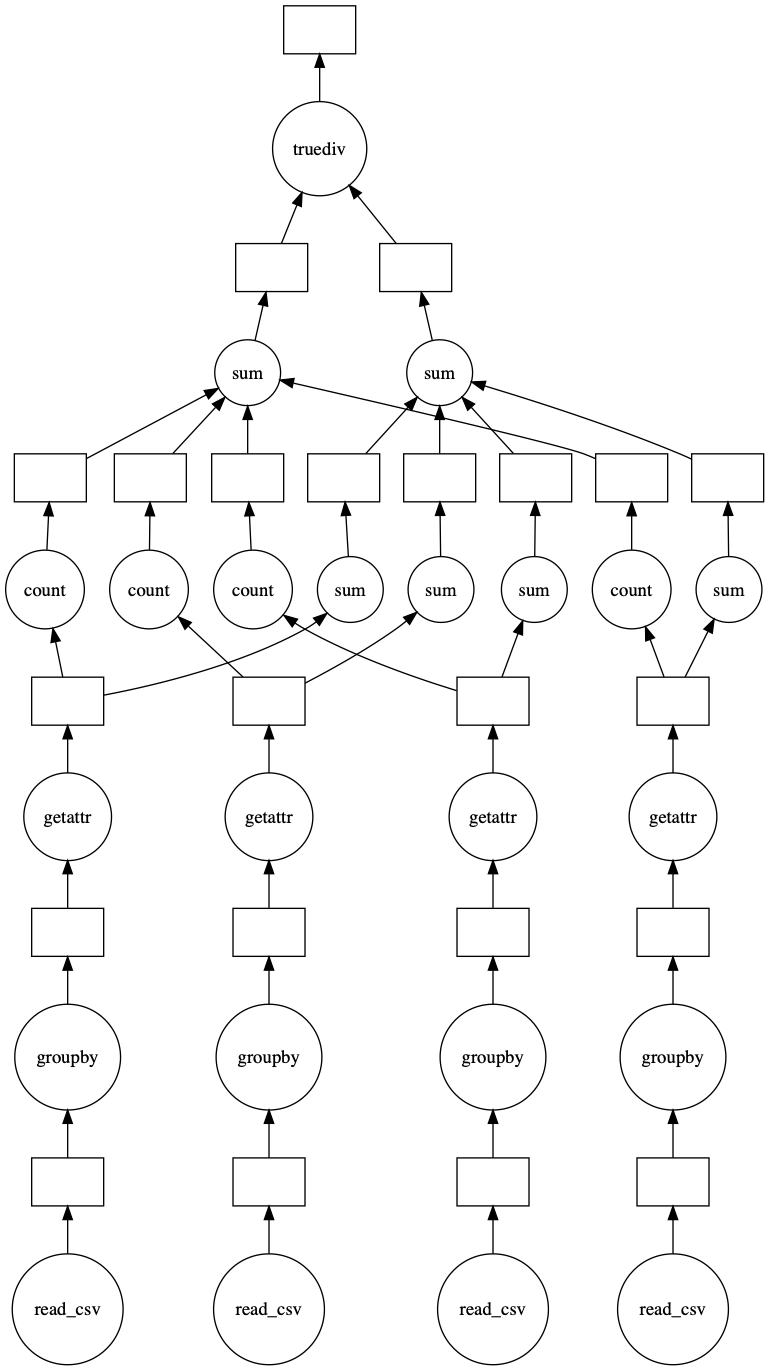

In [26]:
mean.visualize()

In [27]:
%time mean.compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restar

KeyboardInterrupt: 

In [41]:
## At the end close the Dask workers & Client
client.close()